### Importing necessary libs

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import random

import os
print(os.listdir("/data"))

['train.csv', 'images']


### Let's load some data

In [41]:
images = os.listdir("/data/images")
masks = pd.read_csv("/data/train.csv")

# Amount of images in train dataset
print("Images in train dataset: {}".format(len(images)))

# First few rows in masks data
print(masks.head())

Images in train dataset: 192556
         ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


As we can see, there are 192556 images in training dataset. It is possible that some of the images are corrupted. During training process, we would like to remove them from dataset

In [42]:
# Simple function to check if there are any broken images in a directory
def find_broken_images(path) -> list:
    broken = []
    for filename in os.listdir(path):
        try:
            img = Image.open(path + "/" + filename)
            img.verify()
        except:
            broken.append(filename)
    
print(find_broken_images("/data/images"))

None


### Now, let's find the shape and sample a few of our images

In [43]:
image_sample = Image.open("/data/images/" + images[0])

# Printing a shape of an image
print(np.array(image_sample).shape)

(768, 768, 3)


As we can see, images are 768 by 768 pixels and have 3 color channels

In [44]:
# A function to convert a running-length mask to a 2d mask
def rle_decoder(mask, shape=(768, 768)):
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    if type(mask) == str:
        s = mask.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1
    return img.reshape(shape).T

Now we can pick some images from train images and display their mask

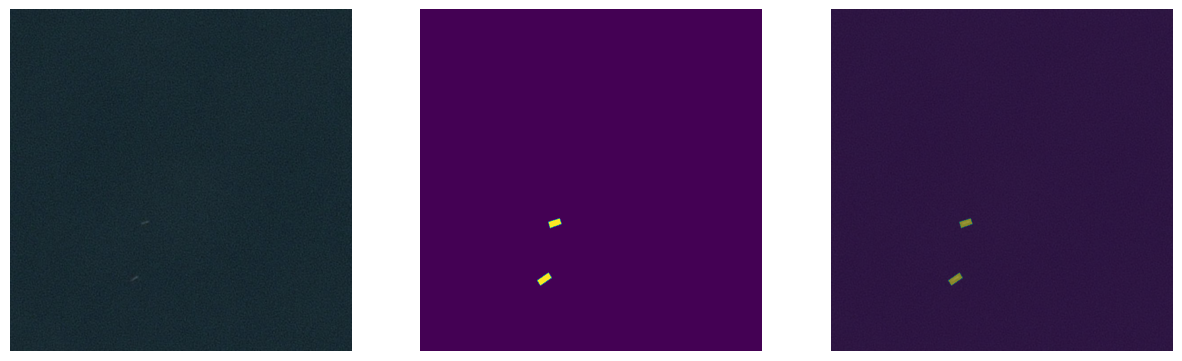

In [45]:
# Selecting random image
ImageId = random.choice(images)

# Opening this image and its respective masks
img = Image.open("/data/images/" + ImageId)
image_masks = masks.loc[masks["ImageId"] == ImageId, "EncodedPixels"].tolist()

# Combining masks
general_mask = np.zeros((768, 768))
for mask in image_masks:
    general_mask += rle_decoder(mask)

# Plotting image and its mask 
fig, axs = plt.subplots(1, 3, figsize=(15, 40))
axs[0].axis("off")
axs[1].axis("off")
axs[2].axis("off")
axs[0].imshow(img)
axs[1].imshow(general_mask)
axs[2].imshow(img)
axs[2].imshow(general_mask, alpha=0.5)
plt.show()

### Further analysis

As we can see by randomly generating images, most of them don't contain any ships. This means, that most likely the data is significantly unbalanced. Let's check so we can account for this during training.

<Axes: >

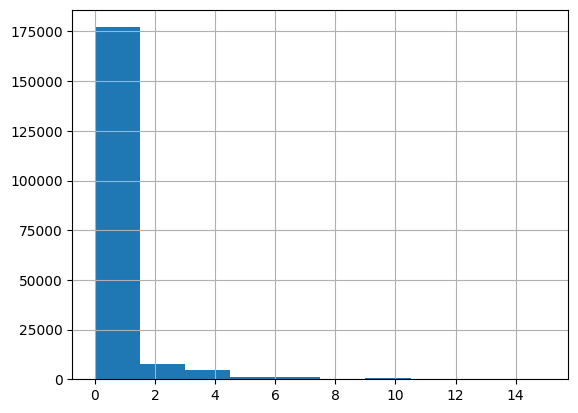

In [46]:
# Checking if mask represents ship
masks["ships"] = masks["EncodedPixels"].map(lambda line: 1 if type(line) == str else 0)

# Grouping by image and counting ships amount
grouped_by_image = masks.groupby("ImageId").agg({"ships" : "sum"}).reset_index()

# Dropping unnecessary column
masks.drop(["ships"], axis=1, inplace=True)

# Creating histogram
grouped_by_image["ships"].hist()

As suspected, most images don't contain any ships, so this needs to be addressed during training.

### Final thoughts
Checking the data provided us with these insights:
1. There are seemingly no broken images in training dataset, but it's better to play safe and leave the checker for corrupted files.
2. Images are 768 by 768 pixels in size, so the network has to work with these dimensions.
3. The dataset is not balanced based on a ship count. Something needs to be done to make it more balanced.